# Walkthrough

Take some **fictional** name / address data, which we imagine has come from different sources and therefore isn't always the same, and figure out which ones refer to the same thing.

In [1]:
import sys
sys.path.append('../src')

In [3]:
import pandas as pd
from normalisation import (
    normalise_names, 
    normalise_addresses, 
    split_address
)
from helpers import (
    save_all_normalised,
    read_all_normalised,
    read_normalised
)

In [4]:
DATA_FOLDER = '../data'
INPUT_FOLDER = f'{DATA_FOLDER}/input'
NORMALISED_FOLDER = f'{DATA_FOLDER}/normalised'
OUTPUT_FOLDER = f'{DATA_FOLDER}/output'

## Load some (fictional data)

Small amount of LLM-generated names and addresses, covering two postcodes.

In [5]:
restaurants = pd.read_csv(f'{INPUT_FOLDER}/restaurants.csv')

In [6]:
# add a unique identifier for each restaurant
import hashlib
def deterministic_row_id(row):
    pieces = [str(row.name)] + [str(v) for v in row.values]
    text = "|".join(pieces)  # delimiter can be anything unambiguous
    return hashlib.md5(text.encode("utf-8")).hexdigest()

# Apply row-wise to get a new column of IDs
restaurants['id'] = restaurants.apply(deterministic_row_id, axis=1)

# make sure the id in the first column
restaurants.insert(0, 'id', restaurants.pop('id'))

In [7]:
restaurants

,id,name,address
0,b6413c2b889bf7f4df0255df4dddfb43,Maple Palace Cafe,"58 College Road, SW4 5VA"
1,2d29b645a21b5a5d9e1809e8c2e48274,Maple Palace Cagfe,"58 Czollege Road, SW45VA"
2,4cfbf0de688327baa977dc1111af41bd,Maplge Palace Cafe,"58 College Rd, SW4 5VA"
3,b4941ace111cbd25bc01342bfbbb1103,Maple Palace Cafqe,"58 ollege Rd, SW45VA"
4,a0375e1f98da5112b291ce24039fd515,Maple Palace Café,"58 Cgllege Road, SW45VA"
...,...,...,...
95,1aadb5fad5a463fdcbf6784812675b16,CrownBridge Restaurant,"7 Anegl Rd, SW4 1ZY"
96,335f20db366bf88af53190525a5d9730,Crown Bridge Restaurant,"7 Angel Road, SW4 1ZY"
97,5f604fff751f1c3042bf2dafa9f5cabe,Crown Bridge Restaurant,"7 Angel Road, SW4 1ZY"
98,602e316cdad470323211180ab874b60e,Crown Bridge Restaurant,"7 Angel Roadj, SW4 1ZY"


## Normalise the data

Consistent capitalisation, split out postcode etc

In [8]:
split = split_address(restaurants['address'])  

restaurants = (
    restaurants
      .assign(
          name = lambda df: normalise_names(df.name),
          address = normalise_addresses(split['address_no_postcode']),
        )
      .join(split['postcode'])
      
)

In [9]:
# We'll group by this when doing the deduplication, so we don't have to 
# compare every pair of restaurants.
restaurants['outcode'] = restaurants['postcode'].str.split(' ').str[0]

In [10]:
# replace some common abbreviations
restaurants['address'] = (
    restaurants['address']
      .str.replace('St ', 'Street ', regex=False)
      .str.replace('Rd ', 'Road ', regex=False)
      .str.replace('Ave ', 'Avenue ', regex=False)
      .str.replace('Dr ', 'Drive ', regex=False)
)

## Save the normalized data

For each group being compared (in this case, defined by outcode), save the normalised data as a csv.

From now on, we'll work with one group at a time.

In [11]:
save_all_normalised(restaurants, NORMALISED_FOLDER)

In [55]:
group = read_normalised('SW4', NORMALISED_FOLDER)

## Pairwise similarity

Within each postcode, compare all pairs and get at similarity score in the 0-1 range.

In [56]:
# cosine similarity 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# use 2 and 3-grams for the names and addresses
# to capture more of the structure of the text
def get_cosine_similarity(series: pd.Series) -> np.ndarray:
    vectorizer = TfidfVectorizer(
        ngram_range=(2, 3),  # use 2-grams and 3-grams
        stop_words='english',  # remove common English stop words
        lowercase=True,  # convert to lowercase
        min_df=1,  # include terms that appear in at least one document
    )
    tfidf_matrix = vectorizer.fit_transform(series)
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return cosine_sim

# compare all pairs of restaurant *names* in the group
name_cosine_sim = get_cosine_similarity(group.name)
address_cosine_sim = get_cosine_similarity(group.address)




## Graph

Create a graph where the nodes are the locations and edges are the similarity scores. Remove edges where similarity is beneath some threshold, then find connected components - which we take to be multiple references to a single location.

(This is also a convenient step to manually add or remove pairs, if we happen to know certain locations are or are not the same)

In [57]:
import networkx as nx

# create a graph from the cosine similarity matrices
G = nx.Graph()

# add edges for pairs of restaurants where both name and address cosine similarity are above a threshold
name_threshold = 0.1
address_threshold = 0.1

# number of restaurants in the group
n = group.shape[0]

for i in range(n):
    for j in range(i + 1, n):
        if name_cosine_sim[i, j] >= name_threshold and address_cosine_sim[i, j] >= address_threshold:
            G.add_edge(group.iloc[i]['id'], group.iloc[j]['id'])

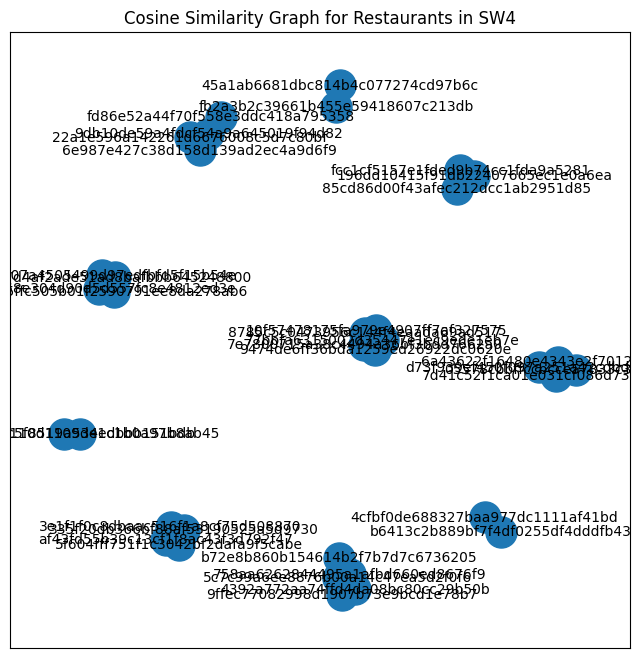

In [58]:
# draw the graph -- just for visualisation (with more than a few notes it's an illegible hairball)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)  
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title('Cosine Similarity Graph for Restaurants in SW4')
plt.show()

## Identify duplicates

We'll say that connected components in our graph are duplicates.

In [59]:
connected_components = list(nx.connected_components(G))

In [61]:
# convert the connected components to a lookup dictionary, where the key is the first restaurant id in the component and the value is a list of all restaurant ids in that component (including the key)
def connected_components_to_lookup(components):
    lookup = {}
    for component in components:
        first_id = next(iter(component))  # get the first id in the component
        lookup[first_id] = list(component)  # convert the set to a list
    return lookup

lookup = connected_components_to_lookup(connected_components)

In [62]:
# create a new group ID column in the group DataFrame
group['group_id'] = group['id'].map(lambda x: next((k for k, v in lookup.items() if x in v), x))

# make sure the id in the first column
group.insert(0, 'group_id', group.pop('group_id'))

In [63]:
# sort by the group id so we can see the groups together
group = group.sort_values(by='group_id').reset_index(drop=True)

## Results

In [67]:
for group_id, group_df in group.groupby('group_id'):
    print(f'Group ID: {group_id}')
    display(group_df[['id', 'name', 'address', 'postcode']])

Group ID: 09a6117985e2a177185947747763e5f2


,id,name,address,postcode
0,09a6117985e2a177185947747763e5f2,happy bridfge cafe,93 colleae rd,SW4 8GM


Group ID: 10f57478175fa979e4907ff7af327575


,id,name,address,postcode
1,7e7800715a38c4494a36bf3bdd7662a0,maple table inn,29 high street,SW4 2SB
2,9474de6ff36bda1259ed26922dc0620e,maple table inn,29 high street,SW4 2SB
3,77bbfa6315002d35447e1ec9ede1eb7e,mpale table inn,29 high street,SW4 2SB
4,8785c5c0473956c144f4eaada69ad517,maple table inn,29 high street,SW4 2SB
5,10f57478175fa979e4907ff7af327575,naple table inn,29 high street,SW4 2SB


Group ID: 1145ffc505b01f2590791ee8da278ab6


,id,name,address,postcode
6,0307d4af2ade51ad8bafbbb645248800,grand palace inn,9 waterloo road,SW4 7PM
7,1145ffc505b01f2590791ee8da278ab6,grand palace inn,9 waterloo road,SW4 7PM
8,7095968e304d90d5d557fc8e4812ed3e,grand palace inn,9 waterloo road,SW4 7PM
9,4a08c07a4505499d97edfbfd5f15b54e,grand palace inn,9 waterloo road,SW4 7PM


Group ID: 19895323a974a4406b02fd7455a2ae13


,id,name,address,postcode
10,19895323a974a4406b02fd7455a2ae13,maple bridgebistro,96 college road,SW4 7XK


Group ID: 1aadb5fad5a463fdcbf6784812675b16


,id,name,address,postcode
11,1aadb5fad5a463fdcbf6784812675b16,crownbridge restaurant,7 anegl rd,SW4 1ZY


Group ID: 1b892dc4a4acc6921cda0a1768a19064


,id,name,address,postcode
12,1b892dc4a4acc6921cda0a1768a19064,oak palace cafe,70 victoria road,SW4 5KR


Group ID: 1caf97dc90c454330a89f4ecedee73ae


,id,name,address,postcode
13,1caf97dc90c454330a89f4ecedee73ae,river bistro grill,9 church street,SW4 4UZ


Group ID: 2bc0b30d110d1109de1c1b0a97b8ab45


,id,name,address,postcode
14,5f1fc4fad9c5f8519a534edbbb151bdb,maple bridge bistro,96 college road,SW4 7XK
15,2bc0b30d110d1109de1c1b0a97b8ab45,maple bridge bistro,96 college road,SW4 7XK


Group ID: 2d29b645a21b5a5d9e1809e8c2e48274


,id,name,address,postcode
16,2d29b645a21b5a5d9e1809e8c2e48274,maple palace cagfe,58 czollege road,SW4 5VA


Group ID: 3e1f1f0c8dbaac516f1a8cf75d508870


,id,name,address,postcode
17,5f604fff751f1c3042bf2dafa9f5cabe,crown bridge restaurant,7 angel road,SW4 1ZY
18,335f20db366bf88af53190525a5d9730,crown bridge restaurant,7 angel road,SW4 1ZY
19,3e1f1f0c8dbaac516f1a8cf75d508870,crown bridge restaurant,7 angel road,SW4 1ZY
20,af43fd55b39c13cf1f8ac43f3d792f47,crown bridge restaurant,7 angel road,SW4 1ZY


Group ID: 4392a772aa74ffd4da08bc80cc29b50b


,id,name,address,postcode
21,4392a772aa74ffd4da08bc80cc29b50b,green spoon restarant,52 green lane,SW4 2GE
22,758aa6262844495a1afbd660ed8676f9,green spoon restaurant,52 green lane,SW4 2GE
23,5c7c99a6ee8876b00a14c47ea5d2f0f6,green spoon restaurant,52 green lane,SW4 2GE
24,b72e8b860b154614b2f7b7d7c6736205,grene spoon restaurant,52 green lane,SW4 2GE
25,9ffec77082998d1907b73e9bcd1e78b7,green spoon rxstaurant,52 green lane,SW4 2GE


Group ID: 469c36880241500238830b74c608b2fe


,id,name,address,postcode
26,469c36880241500238830b74c608b2fe,grand palace inn,9 waterloo rd,SW4 7PM


Group ID: 4cfbf0de688327baa977dc1111af41bd


,id,name,address,postcode
27,b6413c2b889bf7f4df0255df4dddfb43,maple palace cafe,58 college road,SW4 5VA
28,4cfbf0de688327baa977dc1111af41bd,maplge palace cafe,58 college rd,SW4 5VA


Group ID: 5b10fc0e9eddc5b269e9d871a79b0352


,id,name,address,postcode
29,5b10fc0e9eddc5b269e9d871a79b0352,river bistro grilwl,9 church st,SW4 4UZ


Group ID: 602e316cdad470323211180ab874b60e


,id,name,address,postcode
30,602e316cdad470323211180ab874b60e,crown bridge restaurant,7 angel roadj,SW4 1ZY


Group ID: 6a43622f16480e4343e2f70129bb665b


,id,name,address,postcode
31,7d41c52f1ca01e031cf086d737bc3c61,green table kitchen,5 green lane,SW4 7GF
32,6a43622f16480e4343e2f70129bb665b,green table kitchen,55 green lane,SW4 7GF
33,d73f939ef450f097a251a42cdbda7c3a,gdeen table kitchen,5 green lane,SW4 7GF
34,05578cbbffccbcce57833c3b15cd7c18,green table kitchken,5 green lane,SW4 7GF


Group ID: 6e987e427c38d158d139ad2ec4a9d6f9


,id,name,address,postcode
35,9db10de59a4fdcf54a9a645019f94d82,city spoon bistro,56 park road,SW4 8AS
36,22a1e596a142261d6676008c5d7c80bf,city spoon bisitro,56 park road,SW4 8AS
37,fd86e52a44f70f558e3ddc418a795358,cityw spoon bistro,56 park rd,SW4 8AS
38,6e987e427c38d158d139ad2ec4a9d6f9,city spoon byistro,56 park road,SW4 8AS


Group ID: 746cfff7452630314602b23af97ce825


,id,name,address,postcode
39,746cfff7452630314602b23af97ce825,green thble kitchen,5 gree lane,SW4 7GF


Group ID: 7a4a607a43052d1010b1770404ed9665


,id,name,address,postcode
40,7a4a607a43052d1010b1770404ed9665,gregn spoon restaurant,52 geren lane,SW4 2GE


Group ID: 7b200f7cb60ba5e8aaa88e49523174af


,id,name,address,postcode
41,7b200f7cb60ba5e8aaa88e49523174af,maple brirdge bistro,96 college rd,SW4 7XK


Group ID: 85cd86d00f43afec212dcc1ab2951d85


,id,name,address,postcode
42,fcc1cf5157e1fded9b74cc1fda9a5281,happy bridge cafe,93 college road,SW4 8GM
43,85cd86d00f43afec212dcc1ab2951d85,happy bridge café,93 college road,SW4 8GM
44,196dd10415f91db22407665ec1e0a6ea,happy bridge acfe,93 college rd,SW4 8GM


Group ID: a0375e1f98da5112b291ce24039fd515


,id,name,address,postcode
45,a0375e1f98da5112b291ce24039fd515,maple palace café,58 cgllege road,SW4 5VA


Group ID: ab22c25215c4dba875709a5f909d1726


,id,name,address,postcode
46,ab22c25215c4dba875709a5f909d1726,rier bistro grill,9 chruch street,SW4 4UZ


Group ID: adf5dd7f4e50223eb949e7967ae8fa17


,id,name,address,postcode
47,adf5dd7f4e50223eb949e7967ae8fa17,oakopalace café,70 victoria rd,SW4 5KR


Group ID: af5b563d6cb83709ea4f6bf5d94001b9


,id,name,address,postcode
48,af5b563d6cb83709ea4f6bf5d94001b9,city spono bistro,56park rd,SW4 8AS


Group ID: b4941ace111cbd25bc01342bfbbb1103


,id,name,address,postcode
49,b4941ace111cbd25bc01342bfbbb1103,maple palace cafqe,58 ollege rd,SW4 5VA


Group ID: c49d2c9848d960906ff4bd4220be2cdd


,id,name,address,postcode
50,c49d2c9848d960906ff4bd4220be2cdd,oak bistro cafe,48 park road,SW4 9YX


Group ID: cb9e0d07f284d1789ee971efe82c4b74


,id,name,address,postcode
51,cb9e0d07f284d1789ee971efe82c4b74,maple bridge bistro,96 colnege road,SW4 7XK


Group ID: dde7ac077692a5b568a67742e6a830ac


,id,name,address,postcode
52,dde7ac077692a5b568a67742e6a830ac,mavple bridge bistro,96 collegv road,SW4 7XK


Group ID: e50283a60431bdbe36ba28b681b25300


,id,name,address,postcode
53,e50283a60431bdbe36ba28b681b25300,happy bridge café,93 collegte road,SW4 8GM


Group ID: e5d748bd9df62ea5710cb342953e1456


,id,name,address,postcode
54,e5d748bd9df62ea5710cb342953e1456,green table kitchen,5 gree lane,SW4 7GF


Group ID: e97ca3f4e4ee26f55b4f1e9e58ca0182


,id,name,address,postcode
55,e97ca3f4e4ee26f55b4f1e9e58ca0182,maple palaceecafe,58 college road,SW4 5VA


Group ID: f3156b06ce6035b6059ac0a78905ea28


,id,name,address,postcode
56,f3156b06ce6035b6059ac0a78905ea28,urban table restaurant,31 college road,SW4 2CM


Group ID: fb2a3b2c39661b455e59418607c213db


,id,name,address,postcode
57,fb2a3b2c39661b455e59418607c213db,spice fork inn,82 park road,SW4 9SE
58,45a1ab6681dbc814b4c077274cd97b6c,spice fork ibn,82 park rxoad,SW4 9SE


Group ID: fc1b6b18758f3e9047cf1849d8918842


,id,name,address,postcode
59,fc1b6b18758f3e9047cf1849d8918842,golden corner restaurant,46 church road,SW4 5US
